# Tutorial for applying UK Biobank organ aging models
This is a tutorial to apply organ aging models developed in Oh et. al. Nature Medicine 2025 (___), on independent Olink Explore (or later assay version) datasets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm


## Load data

In [2]:
#UK Biobank protein metadata from Supplementary Table 2
ukb_pmd=pd.read_excel("../data_ukb/Ohetal_ST2.xlsx")
ukb_pmd['UniProt_Panel_Assay'] = ukb_pmd['UniProt'] + "_" + ukb_pmd['Panel'] + "_" + ukb_pmd['Assay']
ukb_pmd


,Assay,UniProt,Panel,prot,gene_name,foldchange,organ,enriched,UniProt_Panel_Assay
0,AARSD1,Q9BTE6,Oncology,aarsd1,AARSD1,2.740488,Male,0.0,Q9BTE6_Oncology_AARSD1
1,ABHD14B,Q96IU4,Neurology,abhd14b,ABHD14B,1.034110,Kidney,0.0,Q96IU4_Neurology_ABHD14B
2,ABL1,P00519,Oncology,abl1,ABL1,1.202695,Intestine,0.0,P00519_Oncology_ABL1
3,ACAA1,P09110,Oncology,acaa1,ACAA1,2.080927,Liver,0.0,P09110_Oncology_ACAA1
4,ACAN,P16112,Cardiometabolic,acan,ACAN,30.529169,Artery,1.0,P16112_Cardiometabolic_ACAN
...,...,...,...,...,...,...,...,...,...
2911,ZNRD2,O60232,Oncology,znrd2,SSSCA1,1.372222,Male,0.0,O60232_Oncology_ZNRD2
2912,ZNRF4,Q8WWF5,Oncology,znrf4,ZNRF4,841.292303,Male,1.0,Q8WWF5_Oncology_ZNRF4
2913,ZP3,P21754,Cardiometabolic,zp3,ZP3,1.424956,Male,0.0,P21754_Cardiometabolic_ZP3
2914,ZP4,Q12836,Oncology,zp4,ZP4,15.069991,Female,1.0,Q12836_Oncology_ZP4


In [3]:
#example dataset - 150 healthy, 150 disease
#your data should be preprocessed such that protein column names should match 
#the "prot" column in the protein metadata above
df = pd.read_csv("../data_ukb/Github_mock_data.csv")
df = df.set_index("ID")
df


,Age,Sex,Diagnosis,aarsd1,abhd14b,abl1,acaa1,acan,ace2,acox1,...,zfyve19,zhx2,znf174,znf75d,znf830,znrd2,znrf4,zp3,zp4,zpr1
ID,,,,,,,,,,,,,,,,,,,,,
ID1,56,0,Healthy,1.101938,0.764016,1.050624,0.521391,-0.419203,-0.267352,0.927602,...,2.402261,-0.934651,-0.126525,-2.128250,-0.452224,1.110805,0.671092,1.504468,-1.200986,-0.447269
ID2,69,1,Healthy,-0.109422,-0.412795,0.137824,0.621942,0.744104,1.421105,0.050397,...,0.919430,0.439110,-0.486290,0.315127,-0.673475,1.098476,0.557901,0.757171,-1.519059,0.249888
ID3,58,1,Healthy,0.125544,0.019552,-0.454698,-0.022027,0.955358,-0.407254,-0.660178,...,-1.592927,-0.360077,-1.369203,0.992441,-0.402637,1.322703,-0.038168,1.001478,1.569073,0.759558
ID4,58,1,Healthy,-0.188143,-0.529464,0.085245,0.965508,-0.955874,0.299783,0.760262,...,0.070421,-0.225934,-1.078330,-0.910100,-0.820701,-0.089319,0.063959,-1.422513,-0.442114,-0.249103
ID5,67,0,Healthy,0.073303,-0.040642,-0.247237,0.393368,0.550368,0.117555,-0.696772,...,0.131173,0.070996,-0.271170,0.454836,-0.945848,-0.509458,-0.993401,0.383008,0.013590,-0.390952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID296,45,0,Disease,-0.404047,-0.033918,-0.020433,-2.008662,-0.680486,-1.833727,-0.949737,...,-0.397881,-0.362345,0.703598,0.652553,2.332664,0.474704,0.059605,-1.167617,0.215914,-0.127504
ID297,45,1,Disease,0.052326,-0.269391,0.773577,-0.157705,-0.517332,-0.279710,0.083972,...,-0.118899,1.695460,0.481088,0.315896,-0.068163,-0.350534,-0.160247,0.776400,-1.333543,-0.751519
ID298,43,0,Disease,-1.096504,-0.692246,-1.025149,-0.637458,-0.316214,-0.709323,-0.405995,...,-0.969538,0.365090,-0.846318,-0.025076,-0.247147,-0.910086,-1.272752,-1.149455,0.458830,-0.613196


In [10]:
#separate metadata and protein expression data
md = df.iloc[:,:3]
dfprot = df.iloc[:,3:]


## Test aging models

In [11]:
#Aging model coefficients from Supplementary Table 3
coefdf=pd.read_excel("../data_ukb/Ohetal_ST3.xlsx")
coefdf=coefdf.set_index("organ")
coefdf


,intercept,cd300lg,fabp4,lep,plin1,adipoq,akr1b1,gsta3,scarb1,fdx1,...,mocs2,mslnl,nrxn3,palm2,pbk,pibf1,pzp,ripk4,traf3,upk3bl1
organ,,,,,,,,,,,,,,,,,,,,,
Conventional,57.012438,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Organismal,57.058414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Brain,57.038321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Artery,57.009906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Liver,57.086927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Immune,57.140180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Intestine,57.124332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lung,57.119462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Heart,57.094549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### predict age

In [16]:
toresall = []
for organ in coefdf.index:
    print(organ)

    #extract model coefficients and intercept for a particular organ
    coefsall = coefdf.loc[organ].dropna()
    interc = coefsall.iloc[0]
    coefs = coefsall.iloc[1:]

    #setup results dataframe
    res = md.copy()
    res['organ']=organ

    #predict age as the linear combination of coefficients plus the intercept
    #NPX protein levels should be z-scored
    res['pred_Age']=dfprot[coefs.index].apply(stats.zscore).to_numpy().dot(coefs.to_numpy()) + interc    

    #calculate the age gap based on the predicted vs actual regression line from healthy controls
    res_hc = res.loc[res.Diagnosis=="Healthy"]
    mod = sm.OLS(res_hc['pred_Age'], sm.add_constant(res_hc[['Age']])).fit()
    res['yhat'] = mod.predict(sm.add_constant(res[['Age']]))
    res['agegap'] = res['pred_Age'] - res['yhat']

    #zscore age gaps
    res['agegapz'] = stats.zscore(res.agegap)
    toresall.append(res)

resall = pd.concat(toresall)
resall


Conventional
Organismal
Brain
Artery
Liver
Immune
Intestine
Lung
Heart
Pancreas
Muscle
Adipose
Kidney


,Age,Sex,Diagnosis,organ,pred_Age,yhat,agegap,agegapz
ID,,,,,,,,
ID1,56,0,Healthy,Conventional,57.062752,56.501287,0.561465,0.207399
ID2,69,1,Healthy,Conventional,66.854873,66.309647,0.545226,0.201701
ID3,58,1,Healthy,Conventional,60.407749,58.010265,2.397483,0.851677
ID4,58,1,Healthy,Conventional,55.064424,58.010265,-2.945841,-1.023351
ID5,67,0,Healthy,Conventional,59.401252,64.800669,-5.399416,-1.884337
...,...,...,...,...,...,...,...,...
ID296,45,0,Disease,Kidney,57.037801,57.024668,0.013132,0.054433
ID297,45,1,Disease,Kidney,57.030195,57.024668,0.005527,0.047477
ID298,43,0,Disease,Kidney,56.608171,56.994752,-0.386581,-0.311116


Conventional
Organismal
Brain
Artery
Liver
Immune
Intestine
Lung
Heart
Pancreas
Muscle
Adipose
Kidney


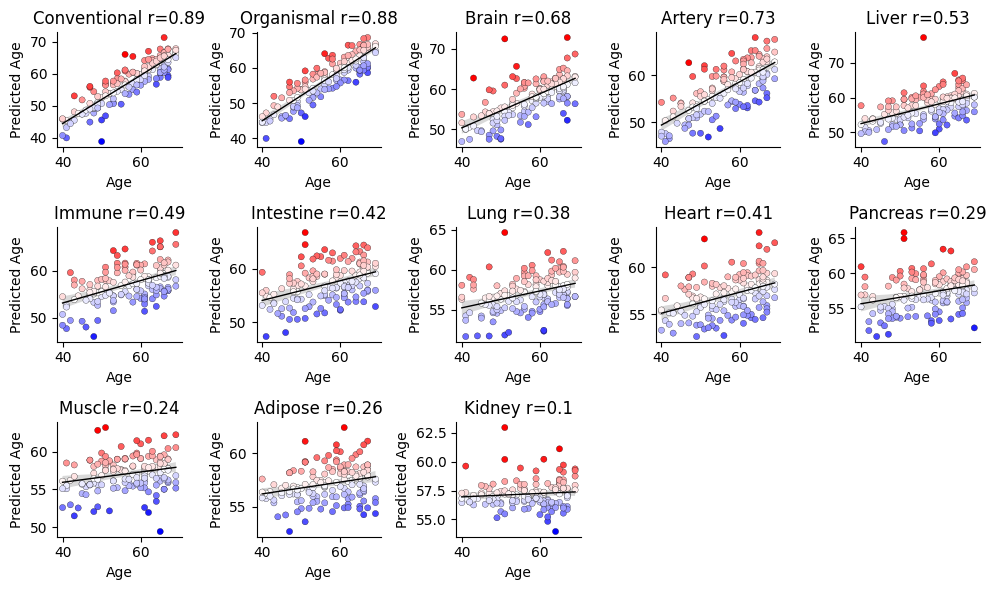

In [22]:
#plot results
ii=0
plt.figure(figsize=(10,6))

for organ in coefdf.index:
    print(organ)
    ii+=1
    plt.subplot(3,5,ii)
    ressub = resall.loc[(resall.Diagnosis=="Healthy") & (resall.organ==organ)]
    
    sns.regplot(data=ressub, x='Age', y='pred_Age', 
                scatter_kws={'s':0},
                line_kws={"color":'black', 'linewidth':1})
    sns.scatterplot(data=ressub, x='Age', y='pred_Age', 
                    s=20, edgecolor='black', linewidth=0.2,
                    hue='agegapz', hue_norm=(-3,3), 
                    palette='bwr',
                    legend=False)
    
    r,p=stats.pearsonr(ressub.Age, ressub['pred_Age'])
    plt.title(organ+' r='+str(round(r,2)))
    plt.ylabel("Predicted Age")
sns.despine()
plt.tight_layout()
plt.show()
